In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline

Welcome to JupyROOT 6.12/06


This file is meant to loop over all of the files in a given list and draw the crystal arrangements of the outliers / any other specified plots

In [2]:
def constructUniqueID( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fill).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandEast).zfill(5)) 
    return uniqueID
def constructUniqueIDwest( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.eventNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandWest).zfill(5)) 
    return uniqueID
def constructUniqueIDeast( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillIndex).zfill(5) +
                            str(entry.calorimeterIndex).zfill(5) + str(entry.islandIndex).zfill(5)) 
    return uniqueID
def constructUniqueIDwave( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandNum).zfill(5)) 
    return uniqueID


def constructConditionFromUniqueIDWest( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && eventNum == "+str(int(uniqueID[10:15]))+
                 " && caloNum == "+str(int(uniqueID[15:20]))+
                 " && islandWest == "+str(int(uniqueID[20:25]))
                )
    
    return condition

def constructConditionFromUniqueIDWave( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && fillNum == "+str(int(uniqueID[10:15]))+
                 " && caloNum == "+str(int(uniqueID[15:20]))+
                 " && islandNum == "+str(int(uniqueID[20:25]))
                )
    
    return condition

def constructConditionFromUniqueIDEast( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && fillIndex == "+str(int(uniqueID[10:15]))+
                 " && calorimeterIndex == "+str(int(uniqueID[15:20]))+
                 " && islandIndex == "+str(int(uniqueID[20:25]))
                )
    
    return condition

In [3]:
#returns the neighboring crystals in a grid in the form of an iterator
def ReturnNeighbors_4(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                yield (int(i), int(j))

In [4]:
def toMap( crystalsInCluster ):
    xtalMapEast = []
    for i in range(54):
        if(i in crystalsInCluster):
            xtalMapEast.append(1)
        else:
            xtalMapEast.append(0)

    xtalMapEast.reverse()
    list1 = []
    list2 = []
    xtal = []
    list2xtal = []
    for crystal in range(54):
        list2.append(xtalMapEast[crystal]) 
        list2xtal.append(crystal)
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal.reverse()
            xtal.append(list2xtal)
            list2xtal = []
    xtal.reverse()
    
    return( list1 )

def arrangeXtals( vec1 ):
    vec1.reverse()
    list1 = []
    list2 = []
    for crystal in range(54):
        list2.append(vec1[crystal]) 
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal = []
    return(list1)

def imshowCompare(vec1, vec2, showPlot = True, savePlot = True, titleString = ''):
    vec3 = []
    for i in range(len(vec1)):
        vec3i = []
        for j in range(len(vec1[0])):
            if(vec1[i][j] > 0.1 and vec2[i][j] > 0.1):
                vec3i.append(2) #both recons include this xtal
            elif (vec1[i][j] > 0.1):
                vec3i.append(1) #only recon east includes this crystal
            elif (vec2[i][j] > 0.1):
                vec3i.append(3) #only recon west
            else:
                vec3i.append(5) #not inluded in either recon's cluster.
        vec3.append(vec3i)
        
    fig, ax = plt.subplots()

    cmap = matplotlib.colors.ListedColormap(['blue', 'xkcd:teal green', 'xkcd:forest green', 'xkcd:light grey'])
    cmap.set_over('xkcd:light grey')
    cmap.set_under('xkcd:light grey')
    
    bounds = [1, 2, 3, 4]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    cax = ax.imshow(vec3, interpolation='nearest', cmap=cmap, vmin=1,vmax=5)
    ax.set_title('Crystals Identified as Part of Cluster(s) in \n Island '+str(titleString))
    cbar = fig.colorbar(cax,
                        cmap=cmap,
                        boundaries = [0] + bounds + [5],
                        extend='both',
                        extendfrac='auto',
                        spacing='uniform',
                        ticks=[x + 0.5 for x in bounds],
                        orientation='vertical')
    cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar
    cbar.ax.set_yticklabels(['East Only', 'Both', 'West Only'])
        
    if(savePlot):
        plt.savefig("./images/CrystalHits_"+str(titleString)+".png",bbox_inches='tight')
        
    if(showPlot):
        plt.show()
    else:
        plt.close()
    
    return(vec3)

In [5]:
#Names of the files to loop over
fileNamesPartial = ["gm2offline_ana_12653990_16369.00449.root",
            "gm2offline_ana_12653991_16369.00045.root",
            "gm2offline_ana_12653992_16367.00444.root",
            "gm2offline_ana_12653993_16358.00045.root",
            "gm2offline_ana_12653994_16355.00098.root",
            "gm2offline_ana_12653995_16369.00495.root",
            "gm2offline_ana_12653996_16369.00129.root",
            "gm2offline_ana_12653997_16356.00472.root",
            "gm2offline_ana_12653998_16370.00100.root",
            "gm2offline_ana_12653999_16368.00142.root",
            "gm2offline_ana_12654000_16358.00108.root",
            "gm2offline_ana_12654001_16362.00028.root",
            "gm2offline_ana_12654002_16370.00193.root",
            "gm2offline_ana_12654003_16364.00096.root",
            "gm2offline_ana_12654004_16367.00414.root",
            "gm2offline_ana_12654005_16367.00137.root",
            "gm2offline_ana_12654006_16357.00150.root",
            "gm2offline_ana_12654007_16357.00046.root",
            "gm2offline_ana_12654008_16370.00438.root",
            "gm2offline_ana_12654009_16364.00339.root",
            "gm2offline_ana_12654010_16358.00008.root",
            "gm2offline_ana_12654011_16368.00282.root",
            "gm2offline_ana_12654012_16363.00212.root",
            "gm2offline_ana_12654013_16369.00099.root",
            "gm2offline_ana_12654014_16367.00496.root",
            "gm2offline_ana_12654015_16362.00160.root",
            "gm2offline_ana_12654016_16363.00311.root",
            "gm2offline_ana_12654017_16368.00107.root",
            "gm2offline_ana_12654018_16356.00104.root",
            "gm2offline_ana_12654019_16370.00040.root",
            "gm2offline_ana_12654020_16363.00374.root",
            "gm2offline_ana_12654021_16370.00393.root",
            "gm2offline_ana_12654022_16359.00111.root",
            "gm2offline_ana_12654023_16369.00492.root",
            "gm2offline_ana_12654024_16359.00065.root",
            "gm2offline_ana_12654025_16358.00375.root",
            "gm2offline_ana_12654026_16363.00094.root",
            "gm2offline_ana_12654027_16367.00093.root",
            "gm2offline_ana_12654028_16370.00218.root",
            "gm2offline_ana_12654029_16368.00396.root",
            "gm2offline_ana_12654030_16365.00141.root",
            "gm2offline_ana_12654031_16356.00210.root",
            "gm2offline_ana_12654032_16367.00251.root",
            "gm2offline_ana_12654034_16364.00077.root",
            "gm2offline_ana_12654035_16363.00257.root",
            "gm2offline_ana_12654036_16367.00005.root",
            "gm2offline_ana_12654037_16367.00128.root",
            "gm2offline_ana_12654038_16365.00367.root",
            "gm2offline_ana_12654039_16358.00025.root",
            "gm2offline_ana_12654040_16363.00479.root",
            "gm2offline_ana_12654041_16369.00155.root",
            "gm2offline_ana_12654042_16368.00421.root",
            "gm2offline_ana_12654043_16356.00252.root",
            "gm2offline_ana_12654044_16358.00237.root",
            "gm2offline_ana_12654045_16355.00136.root",
            "gm2offline_ana_12654046_16358.00053.root"]

#and their paths.
fileNames = ["./data/dataExternal/Oct23DataSet/" + x for x in fileNamesPartial]

In [6]:
#this will be the cut that will determine whether or not something is printed. Written in root format, not pyroot.
condition = "TMath::Abs(deltaE) > 5000" 

#this will be a ttree variable printed on the canvas along with the unique ID. First entry is text, second is what should be 
#     evaluated by the ttree. Newline is there for formatting.
whatsInteresting = ('\n deltaE = ',"(entry.deltaE)") 

Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12653990_16369.00449.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12653991_16369.00045.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12653992_16367.00444.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12653993_16358.00045.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12653994_16355.00098.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12653995_16369.00495.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12653996_16369.00129.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12653997_16356.00472.root
     Matching entries 

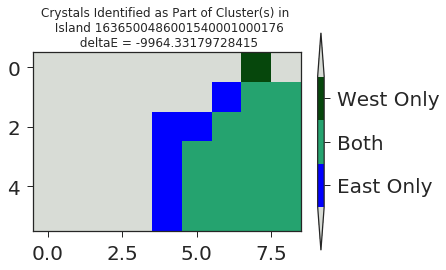

Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654029_16368.00396.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654030_16365.00141.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654031_16356.00210.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654032_16367.00251.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654034_16364.00077.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654035_16363.00257.root
     Matching entries in this file: 1
('\n deltaE = ', '(entry.deltaE)')
-5823.20726659647
     Unique island:  1636200313001780000600176
     deltaE:  -5823.20726659647
          Found another island with this unique ID. Adding their crystals together:
                [0.0, 

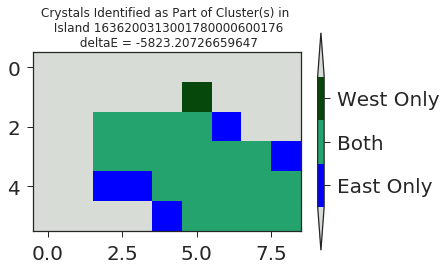

Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654036_16367.00005.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654037_16367.00128.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654038_16365.00367.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654039_16358.00025.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654040_16363.00479.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654041_16369.00155.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654042_16368.00421.root
     Matching entries in this file: 0
Starting file: ./data/dataExternal/Oct23DataSet/gm2offline_ana_12654043_16356.00252.root
     Matching entries 

In [7]:
matchingUniqueIDs = []

for fileName in fileNames:
    try:
        f = r.TFile(fileName)
        twest = f.Get("farline").Get("eventTree")
        teast = f.Get("farline").Get("eastTree")
        tcomp = f.Get("farline").Get("evwTree")
        terr = f.Get("farline").Get("evwNoPartnerTree")
        tcomp2 = f.Get("farline").Get("wveTree")
        terr2 = f.Get("farline").Get("wveNoPartnerTree")
    except:
        print("ERROR: File ", fileName, "not found")
        continue
        
    print("Starting file:", fileName)
    
    dingbefore = 0

    fout = r.TFile("temp_tree_storage.root","recreate")
    tcomp_partial = tcomp.CopyTree(condition)
    print("     Matching entries in this file:", tcomp_partial.GetEntries())
    
    for i, entry in enumerate(tcomp_partial):
        print(whatsInteresting)
        print(eval(whatsInteresting[1]))

        counter = 0
        ding = constructUniqueID(entry)
        matchingUniqueIDs.append( ding )
        if (dingbefore == ding):
            continue

        print("     Unique island: ", ding)
        print("     deltaE: ", entry.deltaE)

        crystalsEast = [x for x in entry.crystalsEast]

        teast_partial = teast.CopyTree( constructConditionFromUniqueIDEast(ding) )
        for k, entry3 in enumerate(teast_partial):
            dong = constructUniqueIDeast(entry3)
            if ding == dong:
                print("          Found another island with this unique ID. Adding their crystals together:")
                print("               ",crystalsEast)
                crystalsEast += [x for x in entry3.crystalsEast]
                print("               ",crystalsEast)

        crystalsWest = []
        twest_partial = twest.CopyTree( constructConditionFromUniqueIDWest(ding) )
        for j, entry2 in enumerate(twest_partial):
            dong = constructUniqueIDwest(entry2)
            if (ding == dong):
                counter = counter + 1
                print("          Found Match (", i, j, counter,")")
                print("              East: ", crystalsEast)
                print("              West: ", [x for x in entry2.crystalsWest])
                crystalsWest += [x for x in entry2.crystalsWest]

        imshowCompare( toMap(crystalsEast), toMap(crystalsWest), True, True,
                      str(ding)+whatsInteresting[0]+str(eval(whatsInteresting[1])) )
        dingbefore = ding

In [8]:
print(matchingUniqueIDs)

[1636500486001540001000176, 1636200313001780000600176]
